# Figure S7: Common Neural Activity during Video On



*Yiyu Wang 2025 May*


In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd

from nilearn.image import new_img_like, concat_imgs, mean_img, math_img
from nilearn import plotting
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img
from scipy.stats import norm
import scipy.stats as stats
from nilearn.maskers import NiftiLabelsMasker


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import math

import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join



/Users/yiyuwang/anaconda3/envs/neuroimaging_env/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [2]:
# local directory set up
gm_mask_img = nib.load('masks/gm_mask_icbm152_brain.nii.gz')

subjects_list = pd.read_csv('Data/included_SocialPred_subjects.csv', header=None)
subjects_list = subjects_list[0].values.tolist()
sample_n = len(subjects_list)
print("subjects in this analysis:")
print(subjects_list)
print(f"**** n = {sample_n} *****" )


TR = .001
N_TR = 675
TR_Length = 0.8
TR_IN_MS = int(TR_Length/TR)

fwhm = 0


subjects in this analysis:
[152, 179, 154, 158, 173, 153, 159, 174, 162, 145, 143, 181, 144, 169, 146, 167, 161, 182, 147, 166, 160, 185, 170, 176, 151, 157, 171, 177, 150, 156]
**** n = 30 *****


In [3]:
# omnibus anova test in design matrix


# beta_dir = 'Results/model_FBvOBS_SubjectivePrior_IncludeNeither_ConcatenateRun_20250328_model3/1stLvl/'
model = 'model_VideoOn'

beta_dir = f'Results/{model}/1stLvl/'

second_level_res_dir = f'Results/{model}/2ndLvl/'
if not os.path.isdir(second_level_res_dir):
    os.mkdir(second_level_res_dir)


vmax = 5
cluster_thre = 30
p_val = 0.05
p_unc = norm.isf(p_val)

p001 = 0.001
p001_unc = norm.isf(p001)

alpha = 0.05


# Univariate to identify common activity between cue and feedback

In [4]:
# design matrix for one sample test

file_list = []
cue_list, fb_list, rest_list = [], [], []

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*cue*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        cue_list.append(1)
        fb_list.append(0)
        rest_list.append(0)
for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*fb*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        cue_list.append(0)
        fb_list.append(1)
        rest_list.append(0)

for s in subjects_list:
    file_name = glob.glob(beta_dir + f'{s}/sub-{s}*z_score*rest*.nii.gz')
    if len(file_name) != 0:
        file_list.append(file_name[0])
        cue_list.append(0)
        fb_list.append(0)
        rest_list.append(1)


        
second_level_input = file_list

design_columns = ['cue', 'fb','rest']

X = pd.concat([pd.Series(cue_list), pd.Series(fb_list), pd.Series(rest_list)], axis=1)
X.columns= design_columns

second_level_input = file_list
print(file_list)
print(len(file_list))


second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=X)

plotting.plot_design_matrix(X, output_file=join(second_level_res_dir, f'design_matrix.png'))
# contrast video vs rest
video_rest_contrast = np.array([0.5, 0.5, -1])  # video on vs rest
cue_fb_contrast = np.array([1, -1, 0])  # cue vs fb


group_res = second_level_model.compute_contrast(video_rest_contrast,output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'video_rest_contrast_{stats_name}.nii.gz'
    print(f"saving {nii_file_path}")
    nib.save(res, nii_file_path)

group_res = second_level_model.compute_contrast(cue_fb_contrast,output_type='all')
for stats_name in group_res.keys():
    res = group_res[stats_name]
    nii_file_path = second_level_res_dir + f'cue_fb_contrast_{stats_name}.nii.gz'
    print(f"saving {nii_file_path}")
    nib.save(res, nii_file_path)


['Results/model_VideoOn/1stLvl/152/sub-152_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/179/sub-179_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/154/sub-154_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/158/sub-158_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/173/sub-173_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/153/sub-153_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/159/sub-159_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/174/sub-174_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/162/sub-162_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/145/sub-145_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/143/sub-143_z_score_video-cue_VideoOn_gm_masked.nii.gz', 'Results/model_VideoOn/1stLvl/181/sub-181_

In [ ]:
# run fdr correction
video_on = nib.load('Results/model_VideoOn/2ndLvl/video_rest_contrast_z_score.nii.gz')
cue_fb = nib.load('Results/model_VideoOn/2ndLvl/cue_fb_contrast_z_score.nii.gz')
video_on_thresholded_map, video_on_second_level_threshold = threshold_stats_img(video_on, 
                                    alpha=0.01,
                                    height_control='fdr', cluster_threshold=30)
print(f"second level threshold: {video_on_second_level_threshold}")

cue_fb_thresholded_map, cue_fb_second_level_threshold = threshold_stats_img(cue_fb,
                                    alpha=0.05,
                                    height_control='fdr', cluster_threshold=30)
print(f"second level threshold: {cue_fb_second_level_threshold}")

# Figure S7 top

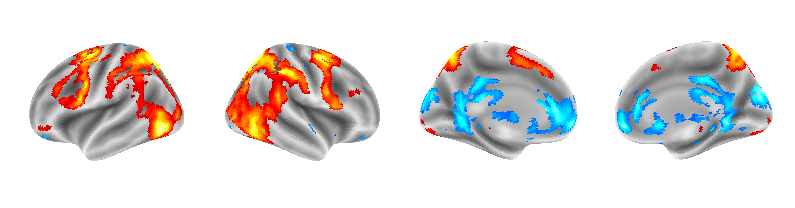

In [20]:

from nilearn.datasets import fetch_surf_fsaverage
from nilearn.plotting import plot_surf_stat_map, show
from nilearn import surface

fsaverage = fetch_surf_fsaverage()

cmap='cold_hot'


# Iterate over each group and plot left & right hemispheres
z_surface = {}
for hemi in ["left", "right"]:
    surface_image = surface.vol_to_surf(
    video_on_thresholded_map,
    surf_mesh=fsaverage[f"pial_{hemi}"],
    inner_mesh=fsaverage[f"white_{hemi}"],
    interpolation='nearest')

    z_surface[hemi] = surface_image

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 20), subplot_kw={'projection': '3d'})
plt.subplots_adjust(wspace=0.01, hspace=0.01) 

# Iterate over each group and plot left & right hemispheres

plotting.plot_surf(
    fsaverage.infl_left, z_surface['left'], view='lateral', hemi='left',
    colorbar=False, cmap=cmap, threshold=video_on_second_level_threshold, 
    avg_method='median', vmin = -7, vmax = 9,
    bg_map=fsaverage.sulc_left, axes=axes[0], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_right, z_surface['right'], view='lateral', hemi='right',
    colorbar=False, cmap=cmap, threshold=video_on_second_level_threshold, 
    avg_method='median', vmin = -7, vmax = 9,
    bg_map=fsaverage.sulc_right, axes=axes[1], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_left, z_surface['left'], view='medial', hemi='left',
    colorbar=False, cmap=cmap, threshold=video_on_second_level_threshold, 
    avg_method='median', vmin = -7, vmax = 9,
    bg_map=fsaverage.sulc_left, axes=axes[2], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_right, z_surface[f'right'], view='medial', hemi='right',
    colorbar=False, cmap=cmap, threshold=video_on_second_level_threshold, 
    avg_method='median', vmin = -7, vmax = 9,
    bg_map=fsaverage.sulc_right, axes=axes[3], darkness=0.8, inflate=True
)

plt.show()

# Figure S7 bottom

In [ ]:
# mask the video on map with the cue-fb map
cue_fb_mask = nib.load('Results/model_final/omnibus_anova_F/omnibus_anova_z_score_fdr.nii.gz')
cue_fb_mask = math_img('img1 == 0', img1=cue_fb_mask)

# exclude the cue-fb map from the video on map
video_on_masked = math_img(f'img1 * img2',
                            img1=video_on_thresholded_map,
                            img2=cue_fb_mask)


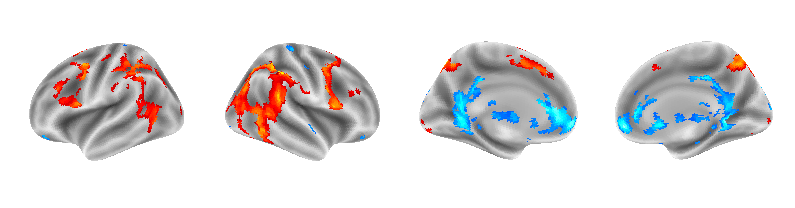

In [23]:
# masked out by anova

fsaverage = fetch_surf_fsaverage()

cmap='cold_hot'


# Iterate over each group and plot left & right hemispheres
z_surface = {}
for hemi in ["left", "right"]:
    surface_image = surface.vol_to_surf(
    video_on_masked,
    surf_mesh=fsaverage[f"pial_{hemi}"],
    inner_mesh=fsaverage[f"white_{hemi}"],
    interpolation='nearest')

    z_surface[hemi] = surface_image

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 20), subplot_kw={'projection': '3d'})
plt.subplots_adjust(wspace=0.01, hspace=0.01) 

# Iterate over each group and plot left & right hemispheres

plotting.plot_surf(
    fsaverage.infl_left, z_surface['left'], view='lateral', hemi='left',
    colorbar=False, cmap=cmap, threshold=video_on_second_level_threshold, 
    avg_method='median', vmin = -7, vmax = 9,
    bg_map=fsaverage.sulc_left, axes=axes[0], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_right, z_surface['right'], view='lateral', hemi='right',
    colorbar=False, cmap=cmap, threshold=video_on_second_level_threshold, 
    avg_method='median', vmin = -7, vmax = 9,
    bg_map=fsaverage.sulc_right, axes=axes[1], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_left, z_surface['left'], view='medial', hemi='left',
    colorbar=False, cmap=cmap, threshold=video_on_second_level_threshold, 
    avg_method='median', vmin = -7, vmax = 9,
    bg_map=fsaverage.sulc_left, axes=axes[2], darkness=0.8, inflate=True
)

plotting.plot_surf(
    fsaverage.infl_right, z_surface[f'right'], view='medial', hemi='right',
    colorbar=False, cmap=cmap, threshold=video_on_second_level_threshold, 
    avg_method='median', vmin = -7, vmax = 9,
    bg_map=fsaverage.sulc_right, axes=axes[3], darkness=0.8, inflate=True
)

plt.show()